In [3]:
with open('data.txt','r') as f:
    raw_text = f.read()

In [4]:
print(raw_text[100:200])

in the United States and
most other parts of the world at no cost and with almost no restrictions
wh


In [5]:
print(f"Total Number of characters: {len(raw_text)}")

Total Number of characters: 92874


## Word Tokenization

In [6]:
import re
vocab = list(set([item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',raw_text) if item.strip()]))
vocab[:20]

['The',
 'suppose',
 'kid',
 'PGLAF',
 'Rock',
 '“‘The',
 'words--',
 'antagonizers',
 'New',
 'willing',
 'stay',
 'some',
 'Oil',
 'staggers',
 'arms',
 'about',
 'Them',
 'layout',
 '“Full',
 'organization']

In [7]:
## Creating token IDs
idx2str = {idx:token for idx,token in enumerate(vocab)}
idx2str[len(idx2str)] = "<UNK>"
idx2str[len(idx2str)] = "<|eot|>"
str2idx = {token:idx for idx,token in idx2str.items()}

print(f"Number of tokens::{len(idx2str)}")

Number of tokens::3361


In [8]:
## Creating a custom tokenizer class

class CustomTokenizerV1():
    def __init__(self, vocab, special_tokens = ["<|eot|>","<|cls|>","<|sep|>"]):
        self.idx2str = {idx:token for idx,token in enumerate(vocab)}
        ## adding special tokens
        self.idx2str[len(self.idx2str)] = "<|unk|>"
        for tok in special_tokens:
            self.idx2str[len(self.idx2str)] = tok
        self.str2idx = {token:idx for idx,token in self.idx2str.items()}
        assert len(self.idx2str) == len(self.str2idx)
        print(f"Total Number of tokens::{len(self.idx2str)}", end = "\n\n")
        print(f"-"*10 + " "+ "Special Tokens" + "-"*10, end = '\n\n')
        for tok in special_tokens:
            print(f"Token ID for {tok}::{self.str2idx[tok]}")

    def encode(self,seq):
        preprocessed = [item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',seq) if item.strip()]
        tokenized = [self.str2idx.get(tok,self.str2idx.get("<|unk|>")) for tok in preprocessed]
        return tokenized

    def decode(self, tok_seq):
        text = ' '.join([self.idx2str.get(item) for item in tok_seq])
        text = re.sub(r'([,.”?/()\'’]|\s)',r'\1',text)
        return text


In [9]:
tokenizer = CustomTokenizerV1(vocab)
seq = "How are you doing charles?"
ids = tokenizer.encode(seq)
tokenizer.decode(ids)



Total Number of tokens::3363

---------- Special Tokens----------

Token ID for <|eot|>::3360
Token ID for <|cls|>::3361
Token ID for <|sep|>::3362


'How are you doing <|unk|> ?'

In [10]:
## using sub-word tokenization from tiktoken (Byte Pair Encoding)
import tiktoken
tokenizer_subword = tiktoken.get_encoding("gpt2")
seq = "How are you doing charles?<|endoftext|>"
ids = tokenizer_subword.encode(seq, allowed_special={"<|endoftext|>"})
for id_ in ids:
    print(tokenizer_subword.decode([id_]))


How
 are
 you
 doing
 char
les
?
<|endoftext|>


## BPE Encoding (Sub-Word Tokenization)

In [11]:

with open('data.txt','r') as f:
    raw_text = f.read()

encoded = tokenizer_subword.encode(raw_text)
print(f"Total number of tokens post encoding::{len(encoded)}")

Total number of tokens post encoding::29698


In [12]:
context_size = 5
X = encoded[:context_size]
y = encoded[1:context_size+1]
print(f"train samples::{X}")
print(f"test samples::{y}")

train samples::[464, 4935, 20336, 46566, 286]
test samples::[4935, 20336, 46566, 286, 1649]


## Creating DataLoader with Sub-Word tokenization

In [13]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from torch import tensor, arange

class GPTDatasetV1(Dataset):

    def __init__(self, txt, context_size, stride, tokenizer):
        self.input_ids = []
        self.output_ids = []
        ## tokenizing the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        ## looping over the sequences
        for i in range(0, len(token_ids) - context_size, stride):
            input_chunk = token_ids[i:i+context_size]
            target_chunk = token_ids[i+1:i+context_size+1]
            self.input_ids.append(tensor(input_chunk))
            self.output_ids.append(tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {"x":self.input_ids[idx],
                "y":self.output_ids[idx]}


def get_dataloader(txt, batch_size = 4, context_size = 1024, stride = 512,
                   shuffle = True, drop_last = True, num_workers = 0):
    '''Creates a dataloader object'''
    ## loading the sub-word tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    ## creating dataset oject
    dataset = GPTDatasetV1(txt, tokenizer=tokenizer,
                           context_size=context_size, stride=stride)
    ## creating the dataloader object
    dataloader = DataLoader(dataset,batch_size=batch_size,
                            drop_last=drop_last,
                            num_workers=num_workers,
                            shuffle = shuffle)
    return dataloader

In [14]:
loader = get_dataloader(raw_text, batch_size=8, 
                        context_size=1024, stride=512)


In [15]:
for batch in loader:
    print("Input Tensor",batch["x"],f"Input Tensor Shape::{batch['x'].shape}",sep = "\n")
    print("--"*10)
    print("Output Tensor",batch["y"],f"Output Tensor Shape::{batch['y'].shape}",sep = "\n")
    break

Input Tensor
tensor([[  314, 43851,    13,  ...,   402,  1647,   263],
        [  220,   220,   220,  ...,    11,   198,  4360],
        [  735,    13, 20494,  ...,   314,  7893,    13],
        ...,
        [  220,   220,   220,  ...,   775,  4539,   656],
        [   13,   198,   198,  ...,  5102,   880,   340],
        [ 4565,  2499,    11,  ...,   649,   304, 30650]])
Input Tensor Shape::torch.Size([8, 1024])
--------------------
Output Tensor
tensor([[43851,    13,   314,  ...,  1647,   263, 13663],
        [  220,   220,   220,  ...,   198,  4360,   314],
        [   13, 20494,   481,  ...,  7893,    13,   198],
        ...,
        [  220,   220,   220,  ...,  4539,   656,  1446],
        [  198,   198,   447,  ...,   880,   340, 18959],
        [ 2499,    11, 23585,  ...,   304, 30650,    13]])
Output Tensor Shape::torch.Size([8, 1024])


## Token Embedding

In [16]:

from torch.nn import Embedding, LSTM, RNN
from torch.optim import Adam, RMSprop, SGD
vocab_size = tokenizer_subword.n_vocab
embedding_dim = 768

embedding_layer = Embedding(vocab_size, embedding_dim)
embedding_layer.weight.shape

torch.Size([50257, 768])

In [17]:
embedding_layer(tensor([[1,2,3, 9 ,8 ,22]])).shape

torch.Size([1, 6, 768])

In [18]:
embedding_layer(batch['x']).shape

torch.Size([8, 1024, 768])

## Positional Embedding/Encoding

In [19]:
## Positional Embeddings (Absolute Positional Encoding)
context_size = 1024
embedding_dim = 768
pos_embedding_layer = Embedding(context_size, embedding_dim)

In [20]:
pos_embedding_layer(arange(context_size)).shape

torch.Size([1024, 768])

In [21]:
embeddings = embedding_layer(batch['x'])
print(f"Embedding Shape::{embeddings.shape}")
pos_embeddings = pos_embedding_layer(arange(context_size))
print(f"Positional Embedding::{pos_embeddings.shape}")
final_input_embedding = embeddings + pos_embeddings
print(f"Embeddings + Positional Embedding::{final_input_embedding.shape}") # this will be the input to the self attention layer

Embedding Shape::torch.Size([8, 1024, 768])
Positional Embedding::torch.Size([1024, 768])
Embeddings + Positional Embedding::torch.Size([8, 1024, 768])


## Attention Mechanisms

### 1. Simplified Attention Mechanism **(No Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**

In [22]:
text = "I see skies of green, red roses too"
token_ids = tokenizer_subword.encode(text)

In [23]:
print(f"Token IDs::{token_ids}")
print(f"Decoded Token IDs::{tokenizer_subword.decode(token_ids)}")

Token IDs::[40, 766, 24091, 286, 4077, 11, 2266, 42152, 1165]
Decoded Token IDs::I see skies of green, red roses too


In [24]:
## Creating an embedding layer
VOCAB_SIZE = tokenizer_subword.n_vocab # Vocab Size of the sub-word tokenizer
EMBEDDING_SIZE = 3 # For Simplicity embedding each token into a 3-Dimensional Space
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

In [25]:
## Creating Embedding of our tokens
embeddings = embedding_layer(tensor(token_ids))
embeddings.shape

torch.Size([9, 3])

In [26]:
embeddings = embeddings.detach().numpy().reshape(-1,3)
for emb, tok in zip(embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")



I --> [-0.0192215  1.8384664 -0.8756974]
see --> [-0.28350946  0.33698788 -1.6581899 ]
skies --> [ 0.45868814  0.06109072 -0.3899582 ]
of --> [ 1.0373682  -1.5015938  -0.13098498]
green --> [ 1.4859557  -0.09925665 -1.7570134 ]
, --> [-1.1492958   0.47446415 -0.41375703]
red --> [0.25665745 0.26500484 0.6563606 ]
roses --> [-0.9418719   0.55742776  0.95664483]
too --> [0.97905517 0.10777056 1.7842482 ]


/Users/sauravnaik/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


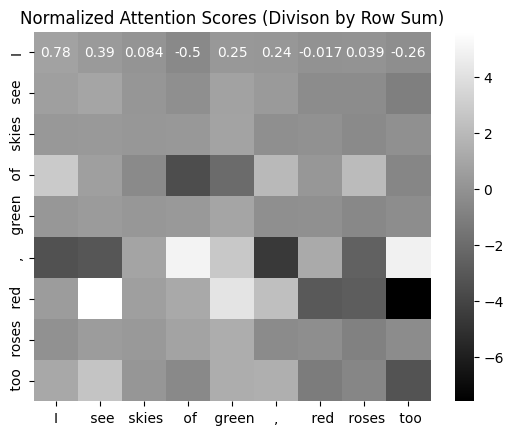

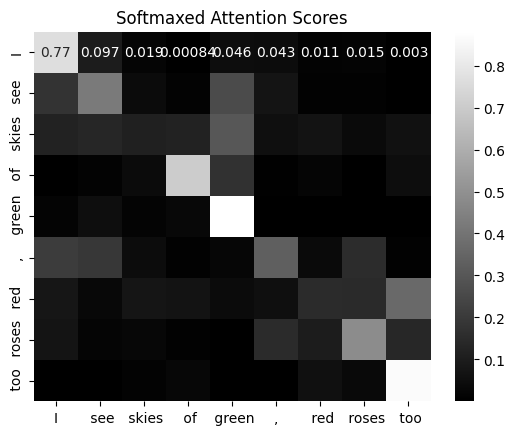

In [27]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def softmax(mat):
    '''Softmax as implemented in pytorch'''
    num_ =  np.exp(mat-np.max(mat, axis=1, keepdims=True))
    denom_ = np.sum(num_, axis=1, keepdims=True)
    return num_/denom_


labels = [tokenizer_subword.decode([i]) for i in token_ids]
attention_scores = embeddings @ embeddings.T
# Normalizing the attention scores by dividing by sum of the corresponding rows
normalized_attention_scores = attention_scores/np.sum(attention_scores, axis=1, keepdims=True)
## Plotting the HeatMap for the Normalized Attention Scores
sns.heatmap(normalized_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Normalized Attention Scores (Divison by Row Sum)")
plt.show();

softmaxed_attention_scores = softmax(attention_scores)
sns.heatmap(softmaxed_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Softmaxed Attention Scores")
plt.show();

In [28]:
context_embeddings = softmaxed_attention_scores @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")

I --> [-0.02182045  1.4685686  -0.9098969 ]
see --> [ 0.20763461  0.46775886 -1.3481883 ]
skies --> [ 0.5600337   0.13395487 -0.74485564]
of --> [ 1.0371732  -1.0496182  -0.33135396]
green --> [ 1.3322821  -0.08220269 -1.6553109 ]
, --> [-0.5003851   0.68457705 -0.50020987]
red --> [0.34647992 0.23579754 0.63949126]
roses --> [-0.45276245  0.5098931   0.5984289 ]
too --> [0.864704   0.09626692 1.5962224 ]


#### Same stuff but using pytorch

In [29]:
import torch
attn_scores = embeddings @ embeddings.T
attn_weights = torch.softmax(tensor(attn_scores), dim = -1)
context_embeddings = attn_weights @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

I --> [-0.02182045  1.4685684  -0.90989685]
see --> [ 0.20763461  0.46775886 -1.3481883 ]
skies --> [ 0.5600337   0.13395488 -0.74485564]
of --> [ 1.0371732 -1.0496182 -0.331354 ]
green --> [ 1.3322821  -0.08220269 -1.6553109 ]
, --> [-0.50038517  0.68457717 -0.5002098 ]
red --> [0.3464799  0.2357975  0.63949126]
roses --> [-0.45276245  0.5098931   0.5984289 ]
too --> [0.8647039  0.09626691 1.5962222 ]


#### We observe our calculations give us similar results

#### Why the need for Trainable Weights?

### 2. Self Attention Mechanism **(With Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**
- Creating *Query*, *Key* and *Value* matrices **(Trainable Weights)**

In [30]:
torch.manual_seed(123)
d_in = EMBEDDING_SIZE
d_out = 2
w_Q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Query Weight Matrix
w_K = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Key Weight Matrix
w_V = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Value Weight Matrix

In [31]:
embeddings_tensors = tensor(embeddings)

In [32]:
query = embeddings_tensors @ w_Q
key = embeddings_tensors @ w_K
value = embeddings_tensors @ w_V
query

tensor([[ 0.3922,  0.4971],
        [-0.1218, -1.3513],
        [ 0.1224, -0.0589],
        [-0.0804, -0.6116],
        [ 0.2851, -0.8232],
        [-0.2515, -0.6255],
        [ 0.1912,  0.8838],
        [-0.0678,  0.7262],
        [ 0.4490,  2.1260]])

#### Can also be done in a different way

In [33]:
## concating query, key and value weights horizontally
q_k_v = torch.concat([w_Q,w_K,w_V], dim = -1)
print(f"Inputs shape::{embeddings_tensors.shape}")
print(f"q_k_v shape::{q_k_v.shape}")
outputs = embeddings_tensors@q_k_v
print(f"Outputs shape::{outputs.shape}")

Inputs shape::torch.Size([9, 3])
q_k_v shape::torch.Size([3, 6])
Outputs shape::torch.Size([9, 6])


In [34]:
query_new, key_new, value_new = torch.hsplit(outputs,3)
query_new==query

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])

In [35]:
attn_scores = query_new @ key_new.T
scaled_attn_scores = attn_scores/torch.math.sqrt(w_K.shape[-1]) ## scaled attention scores
attn_weights = torch.softmax(scaled_attn_scores, dim = -1)

context_vectors = attn_weights @ value_new

print("Context Vectors", end = "\n")
print("--"*10, end='\n\n')
for emb, tok in zip(context_vectors,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

Context Vectors
--------------------

I --> [0.14569901 0.32544285]
see --> [-0.10728025 -0.6414331 ]
skies --> [ 0.05985309 -0.04077596]
of --> [-0.02447343 -0.36160985]
green --> [-0.03925207 -0.3894075 ]
, --> [-0.03203314 -0.3987695 ]
red --> [0.18139386 0.4708105 ]
roses --> [0.15501913 0.33270988]
too --> [0.26778102 0.9756157 ]


#### Why we divide the attention scores by sqrt(key dimension)?
1. **Stability in Learning**

### Causal Attention Layer

In [57]:
CONTEXT_SIZE = 5
inp_text = "Hello How are you?"
embedding_layer = Embedding(tokenizer_subword.n_vocab, 768)
pos_embedding_layer = Embedding(CONTEXT_SIZE, 768)
inp_tok =tokenizer_subword.encode(inp_text)
embeddings = embedding_layer(tensor([inp_tok]))
pos_emb = pos_embedding_layer(torch.arange(tensor(embeddings.shape[1])))
inp_embedding = embeddings + pos_emb


In [221]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length,
                 dropout = 0, q_k_v_bias = False,
                 causal_mask = True):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.dropout = torch.nn.Dropout(dropout)
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        # batch, seq_len, d_in = x.shape
        q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        # print(f"q_k_v shape: {q_k_v.shape}")
        combined_transform = x @ q_k_v
        # print(f"combined_transform shape: {combined_transform.shape}")
        query, key, value = torch.split(combined_transform,self.W_key.shape[-1], dim=2)
        attn_weights = query @ key.transpose(1,2) # (batch X seq_len X seq_len)
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)
        scaled_attn_weights = attn_weights/key.shape[-1]**0.5
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))
        return {"context_vectors": attn_scores @ value,
                "attn_scores": attn_scores} # context rich vectors (batch X seq_len X embedding_dim)


In [222]:
# inp_embedding = torch.concat([inp_embedding]*5, dim = 0)
c_attn = CausalAttention(*(768,768,5), causal_mask=True)
# c_attn(inp_embedding)

In [223]:
for param in c_attn.parameters():
    print(param.shape)

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])


In [224]:
c_attn(inp_embedding)

{'context_vectors': tensor([[[-30.1151, -16.2032,   3.7312,  ..., -17.0823, -12.3906, -12.7336],
          [  6.9410,  -7.1758,  14.9596,  ..., -14.6811,   7.6073,   6.5846],
          [-30.1151, -16.2032,   3.7312,  ..., -17.0823, -12.3906, -12.7336],
          [-32.5164,  -4.0799,  -6.2592,  ..., -13.6605, -14.0177, -37.3766],
          [  2.5552,  41.0171,  37.0916,  ...,  21.3512,  33.7092,  15.0887]],
 
         [[-30.1151, -16.2032,   3.7312,  ..., -17.0823, -12.3906, -12.7336],
          [  6.9410,  -7.1758,  14.9596,  ..., -14.6811,   7.6073,   6.5846],
          [-30.1151, -16.2032,   3.7312,  ..., -17.0823, -12.3906, -12.7336],
          [-32.5164,  -4.0799,  -6.2592,  ..., -13.6605, -14.0177, -37.3766],
          [  2.5552,  41.0171,  37.0916,  ...,  21.3512,  33.7092,  15.0887]],
 
         [[-30.1151, -16.2032,   3.7312,  ..., -17.0823, -12.3906, -12.7336],
          [  6.9410,  -7.1758,  14.9596,  ..., -14.6811,   7.6073,   6.5846],
          [-30.1151, -16.2032,   3.7312

### Muti Head Attention

In [225]:
## applies heads sequentially
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length, num_heads, dropout = 0.0, q_k_v_bias = False):
        super().__init__()
        self.heads = torch.nn.ModuleList([CausalAttention(d_in, d_out,context_length) for _ in range(num_heads)])
    def forward(self, x):
        return torch.concat([head(x)['context_vectors'] for head in self.heads], dim=-1)


In [226]:
multi_attn = MultiHeadAttentionWrapper(768,3,5,10, dropout=0.5)

In [227]:
out_ = multi_attn(inp_embedding)
out_.shape

torch.Size([250, 5, 30])

#### Improving the MultiHead Attention By implementing the heads parallely

In [474]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads,dropout = 0.0, causal_mask = True):
        super().__init__()
        self.num_heads = num_heads
        self.d_out = d_out
        self.W_query = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.dropout = torch.nn.Dropout(dropout)
        self.out_project = torch.nn.Parameter(torch.rand(num_heads *d_out, d_out, dtype=torch.float32))
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        # q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        # Reshape for multi-head attention
        queries = queries.view(batch_size, seq_len, self.num_heads, self.d_out)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.d_out)
        values = values.view(batch_size, seq_len, self.num_heads, self.d_out)

        # Transpose the shapes (Grouping with respect to number of heads)
        queries = queries.transpose(1,2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)

        # Calculating Attention Scores
        attn_weights = queries @ keys.transpose(2,3) # (batch X num_heads X seq_len X seq_len)

        # Adding the Causal Mask
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)

        # Scaling and Softmax the atten scores
        scaled_attn_weights = attn_weights/keys.shape[-1]**0.5
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))
        context_vectors = (attn_scores @ values).transpose(1,2)
        concated_context_vectors = context_vectors.contiguous().view(batch_size,seq_len,-1)
        context_vectors = concated_context_vectors @ self.out_project
        return {"context_vectors": context_vectors,
                "attn_scores": attn_scores} # context vectors (batch X seq_len X embedding_dim)
                                            # attn_scores (batch X num_heads X seq_len X seq_len)



In [475]:
multi_attn = MultiHeadAttention(d_in=768,
                                d_out = 768,
                                num_heads=2,
                                context_length=5,
                                dropout=0.4)

In [476]:
multi_attn(inp_embedding)['context_vectors'].reshape(250,5,-1).shape

torch.Size([250, 5, 768])

In [313]:
after.shape

torch.Size([250, 5, 3, 2])

In [278]:
out_['context_vectors'].shape

torch.Size([250, 5, 768])

In [274]:
out_['attn_scores'].shape

torch.Size([250, 5, 3, 3])

In [363]:
import torch

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout=0.0, causal_mask=True):
        super().__init__()
        self.num_heads = num_heads
        self.d_out = d_out 

        self.W_query = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out))
        self.W_output = torch.nn.Parameter(torch.rand(num_heads * d_out, d_out)) # Output projection

        self.dropout = torch.nn.Dropout(dropout)
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Project input to query, key, and value representations
        queries = x @ self.W_query 
        keys = x @ self.W_key
        values = x @ self.W_value

        # Reshape for multi-head attention
        queries = queries.view(batch_size, seq_len, self.num_heads, self.d_out)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.d_out)
        values = values.view(batch_size, seq_len, self.num_heads, self.d_out)

        # Calculate attention weights
        attn_weights = queries @ keys.transpose(2, 3)  # (batch_size, seq_len, num_heads, seq_len)
        
        # Apply causal mask if needed
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(), -torch.inf)

        # Scale and apply softmax
        scaled_attn_weights = attn_weights / (self.d_out ** 0.5)
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))

        # Calculate context vectors
        context_vectors = attn_scores @ values  # (batch_size, seq_len, num_heads, d_out)

        # Concatenate heads
        context_vectors = context_vectors.view(batch_size, seq_len, -1)

        # Final output projection
        output = context_vectors @ self.W_output 

        return {"context_vectors": output, "attn_scores": attn_scores}